In [24]:
from utils import * 
from algorithms import *
from agents import *
import warnings 
warnings.filterwarnings('ignore')
import torch as th
th.autograd.set_detect_anomaly(True)
seed = 42
th.manual_seed(seed)
np.random.seed(seed)

In [25]:
def loadAlgo(algo, numStates, numActions, algoArgs=[]):
    if algo=='BASE':
        return BASE(numStates, numActions, *algoArgs)
    if algo=='VPG':
        return VPG(numStates, numActions, *algoArgs)
    if algo=='DQN':
        return DQN(numStates, numActions, *algoArgs)
    if algo=='PPO':
        return PPO(numStates, numActions, *algoArgs)
    if algo=='SAC':
        return SAC(numStates, numActions, *algoArgs) 
    if algo=='DDPG':
        return DDPG(numStates, numActions, *algoArgs)  

class Reinforcer(Trader):
    def __init__(self, gameData, disclosure=['currentBid', 'currentAsk', 'buy', 'sell', 'price', 'price'], 
                 index=0, buyer=1, reinforcer=1, numActions=10, algo='VPG', algoArgs=[], depth = 0, verbose = 0):
        super().__init__(gameData, disclosure, index, buyer, reinforcer)
        self.depth = depth
        self.disclosure = disclosure
        self.state = generateState(self)
        self.numStates = 2
        self.numActions = numActions
        self.state = [0]*self.numStates
        self.algo = loadAlgo(algo, self.numStates, self.numActions, algoArgs = [verbose])
        self.done = False
        self.verbose = verbose
    
    def observe(self):
        self.newState = generateState(self)
        if (self.periodSteps == self.numSteps-1): 
            self.done = True
        else:
            self.done = False
        self.algo.observe(self.state, self.action, self.stepProfits, self.newState, self.done)
        if self.verbose == 1:
            print(f'state:{self.state}, action:{self.action}, reward:{self.stepProfits}, newstate:{self.newState},done:{self.done}')
        self.state = self.newState

    def train(self):
        self.algo.train_net()
        
    def bid(self):
        self.stepBid = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            min = self.stepTokenValue * 0.01
            max = self.stepTokenValue * 1.5
            #frac = (F.tanh(torch.tensor(self.action[0])).item()+1)/2
            frac = (self.action[0]+1)/2
            self.stepBid = min*(1-frac) + frac*max
        return self.stepBid
        
    def ask(self):
        self.stepAsk = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            frac = (self.action+1)/2
            min = self.stepTokenValue * 0.5
            max = self.stepTokenValue * 2.0
            #frac = (F.tanh(torch.tensor(self.action[0])).item()+1)/2
            frac = (self.action[0]+1)/2
            self.stepAsk = min * frac + (1-frac) * min
        return self.stepAsk

In [26]:

def generateState(agent):
    counters = [agent.periodSteps, agent.stepTrades] #, agent.periodProfits, agent.stepTokenValue
    disclosureLength = len(agent.disclosure)
    if (disclosureLength == 0) | (agent.depth == 0):
        activityLog = []
    else:   
        if agent.gameSteps >= agent.depth:
            agent.disclosureCopy = deepcopy(agent.disclosure)
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                agent.disclosureCopy.remove('bids')
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                agent.disclosureCopy.remove('asks')
                asksDisclose = True
            
            activityLog = [[]]
            for i in range(1, agent.depth+1):
                activityLog[0] += agent.df.iloc[-i][agent.disclosureCopy].tolist()           
                if bidsDisclose:
                    activityLog[0] += agent.df.iloc[-i].bids
                if asksDisclose:
                    activityLog[0] += agent.df.iloc[-i].asks
            activityLog = activityLog[0]
        else:
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                disclosureLength -= 1
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                disclosureLength -= 1
                asksDisclose = True
            activityLog = [-1] * (disclosureLength*agent.depth + 
                                  bidsDisclose*agent.depth*agent.numBuyers+asksDisclose*agent.depth*agent.numSellers)
        
    state = counters + activityLog
    cleanState = [-1 if np.isnan(x) else x for x in state]
    return cleanState


In [27]:
class PPO(nn.Module):
    def __init__(self, numStates, episodeLength, verbose):
        super(PPO, self).__init__()
        self.data           = []
        self.rollout        = []
        
        self.score          = 0.0
        self.count          = 0
        self.numStates      = 2
        self.gamma          = 0.9
        self.lmbda          = 0.9
        self.learning_rate  = 0.0003
        self.eps_clip       = 0.1
        self.rollout_len    = 1
        self.minibatch_size = 32
        self.buffer_size    = 20
        self.K_epoch        = 20
        self.eta            = 0.0
        self.seed           = 42
        self.done           = False
        self.verbose = verbose
        
        self.fc_mu1   = nn.Linear(self.numStates,64)
        self.fc_mu2   = nn.Linear(64,32)
        self.fc_mu3   = nn.Linear(32,1) # mean action
        self.fc_std1  = nn.Linear(self.numStates,64)
        self.fc_std2  = nn.Linear(64,32)
        self.fc_std3  = nn.Linear(32,1) # std action
        self.fc_v1    = nn.Linear(self.numStates,128)
        self.fc_v2    = nn.Linear(128,64)       
        self.fc_v3    = nn.Linear(64,1) # value function
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.optimization_step = 0
        torch.nn.init.orthogonal_(self.fc_mu1.weight)
        torch.nn.init.orthogonal_(self.fc_mu2.weight)
        torch.nn.init.orthogonal_(self.fc_mu3.weight)
        torch.nn.init.orthogonal_(self.fc_std1.weight)
        torch.nn.init.orthogonal_(self.fc_std2.weight)
        torch.nn.init.orthogonal_(self.fc_std3.weight)
        torch.nn.init.orthogonal_(self.fc_v1.weight)
        torch.nn.init.orthogonal_(self.fc_v2.weight)
        torch.nn.init.orthogonal_(self.fc_v3.weight)

    def act(self, s):
        mu, std = self.pi(torch.from_numpy(np.array(s)).float())
        std = torch.clamp(std, self.min_std, self.max_std)
        dist = Normal(mu, std)
        if verbose == 1:
            print('\nmu',mu.item(),'std',std.item())
        a = dist.sample()
        self.a = torch.tanh(a)
        self.log_prob = -0.5 * ((a - mu) / std)**2 - 0.5 * np.log(2 * np.pi) - torch.log(std)
        return [self.a.item()]
        
    def observe(self, s, a, r, s_prime, done):
        self.done = done
        self.rollout.append((s, self.a, r, s_prime, self.log_prob.item(), done))
        if len(self.rollout) == self.rollout_len:
            self.put_data(self.rollout)
            self.rollout = []
        self.count += 1
        self.score += r
    
    def pi(self, x, softmax_dim = 0):
        mu  = F.leaky_relu(self.fc_mu1(x))
        mu  = F.leaky_relu(self.fc_mu2(mu))
        mu  = F.tanh(self.fc_mu3(mu))
        std = F.leaky_relu(self.fc_std1(x))
        std = F.leaky_relu(self.fc_std2(std))
        std = F.softplus(self.fc_std3(std)-self.eta)
        return mu, std

    def v(self, x):
        v = F.leaky_relu(self.fc_v1(x))
        v = F.leaky_relu(self.fc_v2(v))
        v = self.fc_v3(v)
        return v

    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(self.buffer_size):
            for i in range(self.minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                td_target = r + self.gamma * self.v(s_prime) * done_mask
                delta = td_target - self.v(s)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = self.gamma * self.lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv

    def train_net(self):
        if len(self.data) == self.minibatch_size * self.buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data)

            for i in range(self.K_epoch):
                for mini_batch in self.data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch

                    mu, std = self.pi(s, softmax_dim=1)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target)

                    self.optimizer.zero_grad()
                    loss.mean().backward()
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                    self.optimizer.step()
                    self.optimization_step += 1

In [28]:
import warnings
from copy import deepcopy
warnings.filterwarnings('ignore')
numRounds, numPeriods, numSteps = 1, 10000, 9
numBuyers, numSellers, numTokens = 3, 6, 4
gameTypes, seed = '1001', 42
#disclosure = ['currentBid', 'currentBidIdx','currentAsk', 'currentAskIdx','buy','sell','price','sale', 'bids', 'asks']
disclosure = []
depth = 0
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
verbose = 0
numStates = 2
# ZeroIntelligence, TruthTeller
buyers = [
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, algo = 'PPO', verbose = verbose),
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, algo = 'PPO', verbose = verbose),
]
sellers = [
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
          ]
log = Log(gameData, disclosure)
rnd = 0
startRounds(gameData, log, buyers, sellers, rnd)

In [29]:
buyers[0].state

[0, 0]

In [30]:
print_interval = 100
#verbose = 1
for rnd in range(numRounds):
    startRounds(gameData, log, buyers, sellers, rnd)
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        profits = []
        bids_ = []
        for step in range(numSteps):
            if verbose == 1:
                print('\nstart')
            startSteps(buyers, sellers)
            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            if verbose == 1:
                print('bid', bids[0], 'profit', buyers[0].stepProfits)
                
            with torch.no_grad():
                profits.append([buyers[0].stepProfits,buyers[1].stepProfits])
                bids_.append([bids[0],bids[1]])
            log.addStep([rnd, period, step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            updateStates(buyers, sellers)
            updatePolicy(buyers, sellers)
            endSteps(buyers, sellers)
            
        if period%print_interval == 0:
            with torch.no_grad():
                print('\t')
                print(rnd, period, np.nanmean(bids_, axis = 0), np.sum(profits,axis=0)/print_interval)
                buyers[0].algo.score = 0
                #display(log.getPeriod(0, period))
                pass
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)
    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 2x64)

In [ ]:
log.graphTraining(maxNumPeriods=100, skip = 20, trackBuyersIdx = [0, 1])

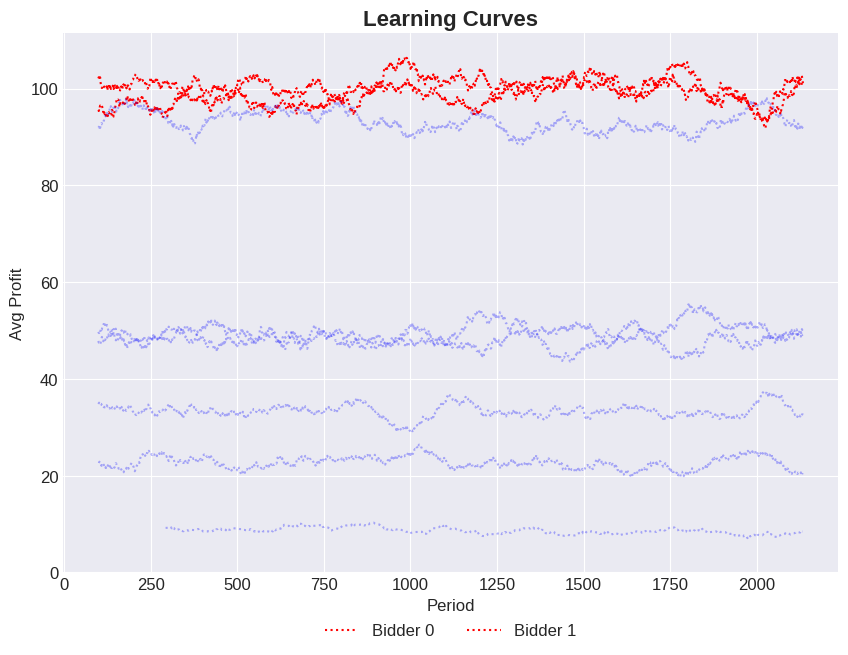

In [27]:
log.graphLearning(trackBuyersIdx = [0,1], trackSellersIdx = [], rolling_window=100, type = 'period')

In [ ]:
log.stepData.tail(10)

In [ ]:
log.graphSales(0, 4887, trackBuyersIdx=[0], trackSellersIdx=[])

In [ ]:
log.graphOffers(0, 4888, trackBuyersIdx=[0], trackSellersIdx=[])